# SLT-CE-7: Mean Field Approximation

**Solve the main part of the exercise to get 1 point. Solve the extension as well to get 2 points.**

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt18_lecture06.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise10.pdf)

[3] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[4] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[5] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

We will be using the Ising model from the coding exercise 2 for image denoising, also described in Series 10 [2]. Recall that the model orignates from section 8.3.3 of [4]. However, to approximate the inference, instead of using MCMC, we will apply mean field approximation and then compare it to the MCMC estimates.

## Setup

We start by importing necessary python packages.

In [11]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import convolve
import time

We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [12]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [13]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

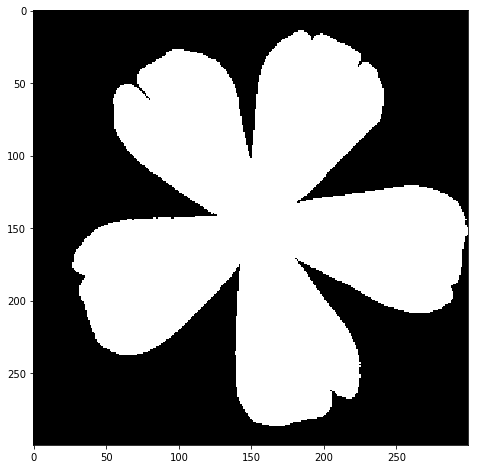

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [15]:
# Fix random seed for reproducibility
def get_noisy_img(img):
    np.random.seed(13)
    h, w = img.shape
    IMG_NOISY_OBSERVATION = img.copy()
    num_flips = int(0.3 * h * w)

    perm = np.random.permutation(img.size)[0:int(0.3 * img.size)]
    
    for k in perm:
        i = int(k/w)
        j = k%w
        IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]
        
    return IMG_NOISY_OBSERVATION
    

Plot the noisy version of the original image

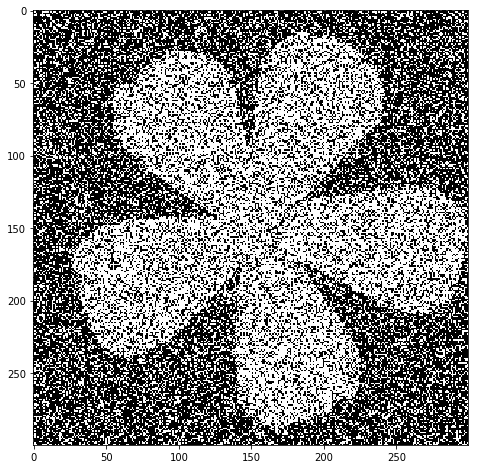

In [16]:
IMG_NOISY_OBSERVATION = get_noisy_img(IMG_ORIGINAL)
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as given in [2].

In [17]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [18]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

Estimating loss via mean squared error

In [19]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [20]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [21]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-773448.0
-300856.0


## Problem 0

Describe the basics of the mean field approximation:
### Objective
We have some given posterior distribution $p(x|y)$ which is intraceable. So what we can do is we think of an approx. distribution $q(x)$ with which we want to approximate $p(x|y)$. This is then turned into an optimization problem by saying that we choose the parameters of our proposal distribution by $min D_{q} (p || q)$. Since p is still not traceable normally what is done is to switch p & q and then replace p by $\hat{p} = Zp$ which results in $min D_{q} (q || p)- log(Z)$ and the constant will just fall out so that we're left with 2 traceable distributions. 
### Connection to mean field 
In the mean field method we assume for our approx. distribution that it is fully factorizable: $q(x) = \prod_{i=1}^N q_i(x_i;u_i)$. So our objective becomes $min_{q_1, ..., q_N} D_{KL} (q || p )$.
This results then commonly in an update rule in style of: $log q_j(x_j)=E_{-q_j}[log \hat p(x)] + const$. By $-q_j$ is meant expectation over all except when $i==j$.Also to note is that the factorization happens normally more like a conditional independance by the parameter $u_i$ that is derived from the neighbors of $x_i$

## Problem 1

With the help of [2], explain the algorithm for solving image denoising using mean field approximation. <br>
So I hope you don't mind but i like the probabilistic approach that murphy https://www.cs.ubc.ca/~murphyk/MLbook/ took way more than this more physical / frequentist approach with risk that we saw in lecture and therefore used this and explain it with this. With the more probabilistic view I also abandoned the strange h, sigma thing and use just playin x for the denoised image and y for the noisy one. <br>

#### Key Idea
The idea that helped me the most to understand this image denoisening is the following: Which denoised image explains/produced the noisy image best. This makes the most sense since in the most cases it also happens this way anyway. So basically what we want to find is $argmax_{p(x)} p(x, y) = argmax_{p(x)} p(x)p(y|x)$. So again which perfect image x explains the noisy image y best. 

#### Model 
##### prior
We use the ising model so we get the prior already for free: $p(x) = \dfrac{1}{Z} exp(-E(x)) = \dfrac{1}{Z} exp(-E(\sum_i \sum_{j \in NN(i)} x_i w_{i,j} x_j))$ and since we know from theory that we just take the logarithm and Z is left as a constant. So we can ignore this term. Note that this prior obviously favors big patches of constant values. 

#### likelihood 
The likelihood $p(y|x) = \prod_i p(y_i | x_i) = \sum_i exp(-L_i(x_i))$ for some loss function $L_i$. We will use some gaussian loss function despite the fact that we have multinomial noise which makes the whole thing more interesting for sure. 
#### posterior 
Now we can calculate the posterior pretty easily. $p(x|y) = \dfrac{p(y|x)p(x)}{p(x,y)} = 1/Z exp(\sum_i L_i(x_i) - E(x)$ but this is really hard to optimize. 
#### Solution to the posterior problem 
So what us helps out is if we think that our posterior can be factorized as $q(x) = \prod_i q_i(x_i; \mu_i)$ where we baiscally replaced the dependance on the neighbors by some "summary" $\mu_i$  of the neighbors that we can calculate independantly. 
#### new prior
As a result we get a new prior that we calculate via: $log \hat{p}(x_i) = x_i \sum_{j \in NN(i)} W_{i,j} \mu_i + L_i(x)$. Note that in a practical implementation we have a constant $W_{i,j} = J$ for all i,j. And a result of that we have basically a convolution of a 3x3 kernel with i,i = 0. This is implemented in `def log_prior(x):`. The $L_i$ part is implemented as the `logodds = np.log(norm.pdf(img_noisy_observation, loc=1, scale=sigma)) - np.log(norm.pdf(img_noisy_observation, loc=-1, scale=sigma))` term. 

#### mean field update
Since we encapsulated the whole thing into $\mu$ we have to update this term , too. So what we calculate is $\mu = E[x_i] = 1*P(x_i = 1)+(-1)*P(x_i = -1) = $ (see murphy (21.46)) $ = tanh(\sum_{j \in NN(i)} W_{i,j} \mu_j + 0.5*(L_i(+1) - L_i(-1)) $ 

#### damped update
A little twist murphy recommends is that one uses damped update where you take with you a part of the old value. and this is then also the second equality in the code `img_noisy_observation = (1 - lambdaz) * img_noisy_observation + lambdaz * np.tanh(log_prior(img_noisy_observation) + .5 * logodds)`

## Problem 2

Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the epochs parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.

Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Clearly explain the differences. Does it converge faster? What are the disadvantages and advantages?

Consider running the comparison on another image to prove your point.

Also, feel free to replace our implementation of MCMC with your own.

In [22]:
def metropolis(img_noisy_observation, img_original, epochs, **kwargs):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    T = 1.0

    energy_vals = []
    loss = []

    for e in range(epochs):
        for i in range(1,img_original.shape[0]+1):
            for j in range(1,img_original.shape[1]+1):
                # calculate local energy
                pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # flip the pixel
                img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # calculate new local energy
                pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # energy difference
                dE = pixel_new_energy - pixel_cur_energy
                # do metropolis thingy
                if dE > 0:
                    p = 0.5*(1-np.tanh(0.5 / T * dE))
                    rr = np.random.rand(1)
                    if rr > p:
                        # revert back pixel
                        img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                    # append energy
                if j % 200 == 0:
                    energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                    loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))

    return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss)

In [23]:
from scipy.signal import correlate2d
from scipy.stats import norm

def meanfield(img_noisy_observation, img_original, epochs, sigma=1.5, lambdaz=0.5):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    print('Meanfield(lambda: {}, sigma: {}, epochs: {})'.format(lambdaz, sigma, epochs))
    # initialize params
    img_noisy_observation = img_noisy_observation.copy()
    # this is unnormalized since the normalized can't be approx. see notes above. 
    # log(ṕ(x)) = log(Zp(x)) = log(Z) + log(p(x)) 
    # where p(x) = sum_i sum_j W_ij x_i x_j with j neighbor of i
    def log_prior(x):

        kernel = np.array([[1, 1, 1],[1, 0, 1],[1, 1, 1]])
        result = correlate2d(x, kernel, mode='same')
        return result
    
    energies = []
    losses = []
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    # artifically construct energies and losses arrays
    for i in range(epochs):
        logodds = np.log(norm.pdf(img_noisy_observation, loc=1, scale=sigma)) - np.log(norm.pdf(img_noisy_observation, loc=-1, scale=sigma))
        img_noisy_observation = (1 - lambdaz) * img_noisy_observation + lambdaz * np.tanh(log_prior(img_noisy_observation) + .5 * logodds)

        E = energy(img_noisy_observation, img_noisy_observation)
        L = mse_loss(img_noisy_observation, img_original)
        energies.append(E)
        losses.append(L)
    return img_noisy_observation, np.asarray(energies), np.asarray(losses)


In [24]:
def evaluate(method, img_noisy_observation, img_original, epochs=1, **kwargs):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs, **kwargs)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

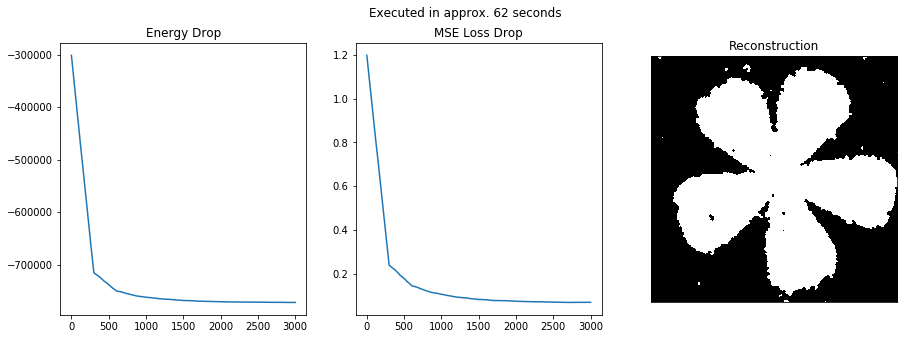

CPU times: user 1min 2s, sys: 515 ms, total: 1min 2s
Wall time: 1min 2s


In [25]:
%%time
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

Meanfield(lambda: 0.5, sigma: 1.5, epochs: 15)


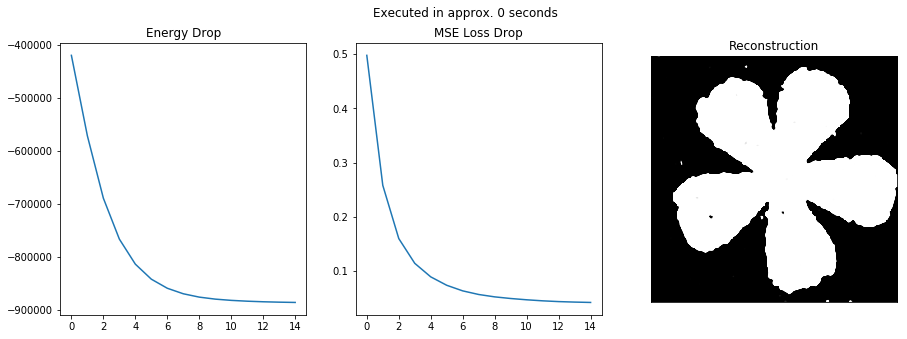

CPU times: user 697 ms, sys: 23.9 ms, total: 721 ms
Wall time: 717 ms


In [26]:
%%time
# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15)

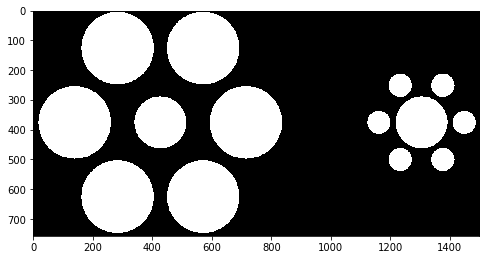

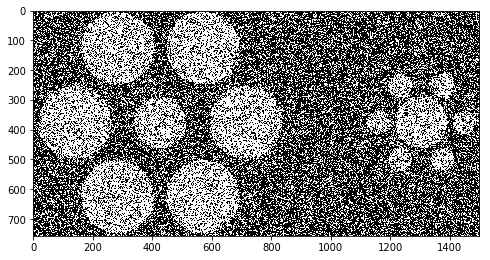

Meanfield(lambda: 0.5, sigma: 1.5, epochs: 15)


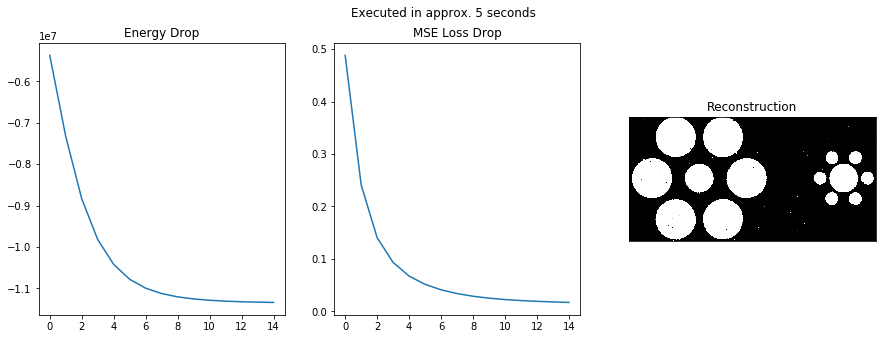

In [27]:
IMG_CIRCLES = mpimg.imread("circles.png")#[:,:,0]/255
IMG_CIRCLES[IMG_CIRCLES > 0.5] = 1
IMG_CIRCLES[IMG_CIRCLES <= 0.5] = -1
IMG_CIRCLES = IMG_CIRCLES[:,:,3]

plt.figure(figsize=(8,8))
plt.imshow(IMG_CIRCLES, cmap='gray')
plt.show()

# Fix random seed for reproducibility
IMG_CIRCLES_NOISY = get_noisy_img(IMG_CIRCLES)
    
plt.figure(figsize=(8,8))
plt.imshow(IMG_CIRCLES_NOISY, cmap='gray')
plt.show()

# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_CIRCLES_NOISY, IMG_CIRCLES, 15)

Compare and analyze performance:

1) It astonished me how much faster the mean field approximation is. Not even a full second for the mean field case and roughly 1 minute for the metropolis. But one has to note obviously that we can't conclude on the CPU operations since the mean field approach is HIGHLY parallizable. <br>
2) But its still amazing how fast it is, even with such a big image as the one with the circles from above. 


Any implementation/computational/numerical issues?

## Problem 3

Comment on the convergence of the method. How can we tell if the mean field convereged? Do we always reach the global optimum? <br>
1) We can only infere if the mean field has converged by checking if the norm of the change of the mean values is small. <br>
2) No we don't. This is not in any way convex. And we approach some local minima which of course could be a global. But it is in no way certain. 

## Problem 4

How do the parameters of the Ising model, and the tempereature affect the performance of the mean field?

Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. Can you explain the behaviour?

Meanfield(lambda: 0.0, sigma: 1.5, epochs: 10)
Meanfield(lambda: 0.1, sigma: 1.5, epochs: 10)
Meanfield(lambda: 0.2, sigma: 1.5, epochs: 10)
Meanfield(lambda: 0.30000000000000004, sigma: 1.5, epochs: 10)
Meanfield(lambda: 0.4, sigma: 1.5, epochs: 10)
Meanfield(lambda: 0.5, sigma: 1.5, epochs: 10)
Meanfield(lambda: 0.6000000000000001, sigma: 1.5, epochs: 10)
Meanfield(lambda: 0.7000000000000001, sigma: 1.5, epochs: 10)
Meanfield(lambda: 0.8, sigma: 1.5, epochs: 10)
Meanfield(lambda: 0.9, sigma: 1.5, epochs: 10)
Meanfield(lambda: 1.0, sigma: 1.5, epochs: 10)


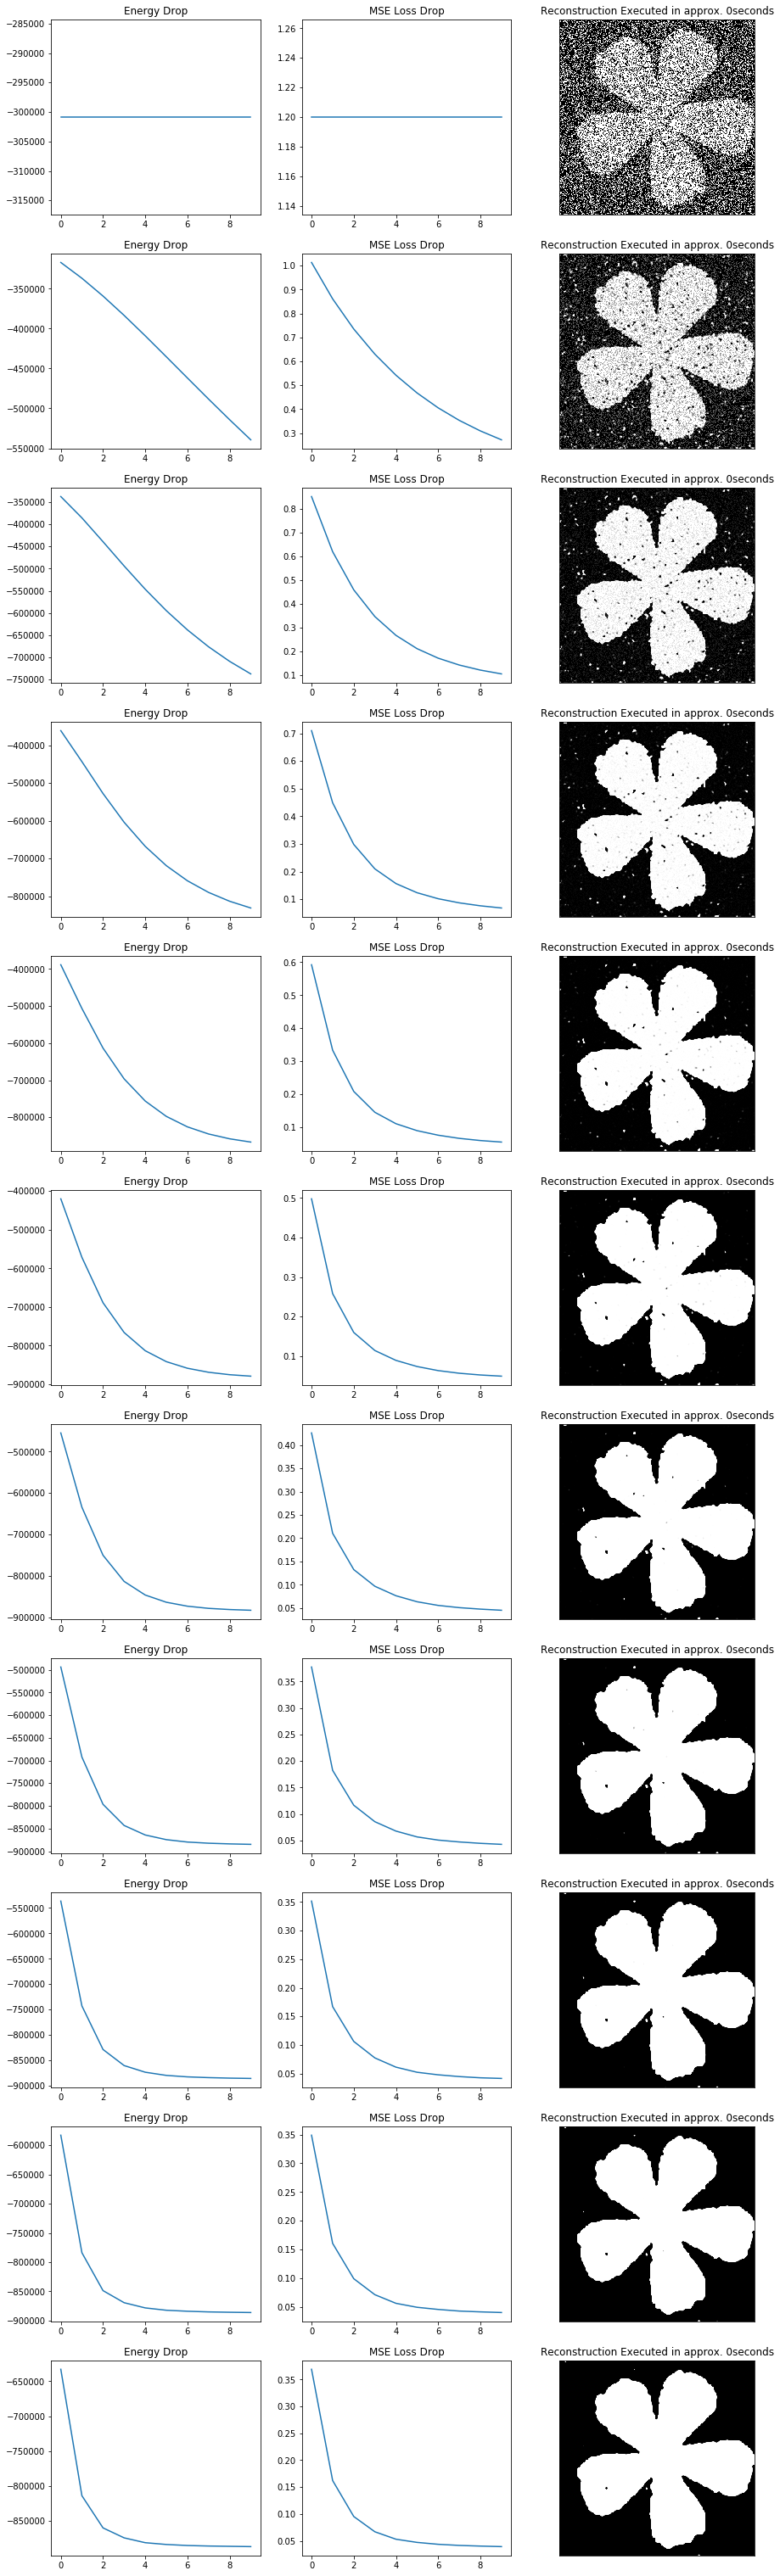

In [28]:
# Lets find out how sigma influences the mean field algorithm #
# The equations would suggest that the nearer lambda is by 0 the more influence has the old value vs.
# the neighbooring terms 
lambdas = np.arange(0,1.1, 0.1)
f, ax = plt.subplots(len(lambdas), 3, figsize=(15,5*len(lambdas)))
for i,l in enumerate(lambdas):
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = meanfield(IMG_NOISY_OBSERVATION, IMG_ORIGINAL, epochs=10, lambdaz=l)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax[i,0].plot(energies)
    ax[i,0].set_title('Energy Drop')
    ax[i,1].plot(losses)
    ax[i,1].set_title('MSE Loss Drop')
    ax[i,2].imshow(img_estimate, cmap='gray')
    ax[i,2].set_title('Reconstruction Executed in approx. ' +str(int(execution_time)) + 'seconds')
    ax[i,2].get_xaxis().set_visible(False)
    ax[i,2].get_yaxis().set_visible(False)

# So after executing the test it is quite obvoius that if lambda = 0 
# we don't change any value since the old value is only asked 
# the bigger lambda gets the more influence the surrounding neighbors have and the more aggressive 
# old values get overtaken

Meanfield(lambda: 0.5, sigma: 0.1, epochs: 15)
Meanfield(lambda: 0.5, sigma: 0.6, epochs: 15)
Meanfield(lambda: 0.5, sigma: 1.1, epochs: 15)
Meanfield(lambda: 0.5, sigma: 1.6, epochs: 15)
Meanfield(lambda: 0.5, sigma: 2.1, epochs: 15)
Meanfield(lambda: 0.5, sigma: 2.6, epochs: 15)
Meanfield(lambda: 0.5, sigma: 3.1, epochs: 15)
Meanfield(lambda: 0.5, sigma: 3.6, epochs: 15)
Meanfield(lambda: 0.5, sigma: 4.1, epochs: 15)
Meanfield(lambda: 0.5, sigma: 4.6, epochs: 15)


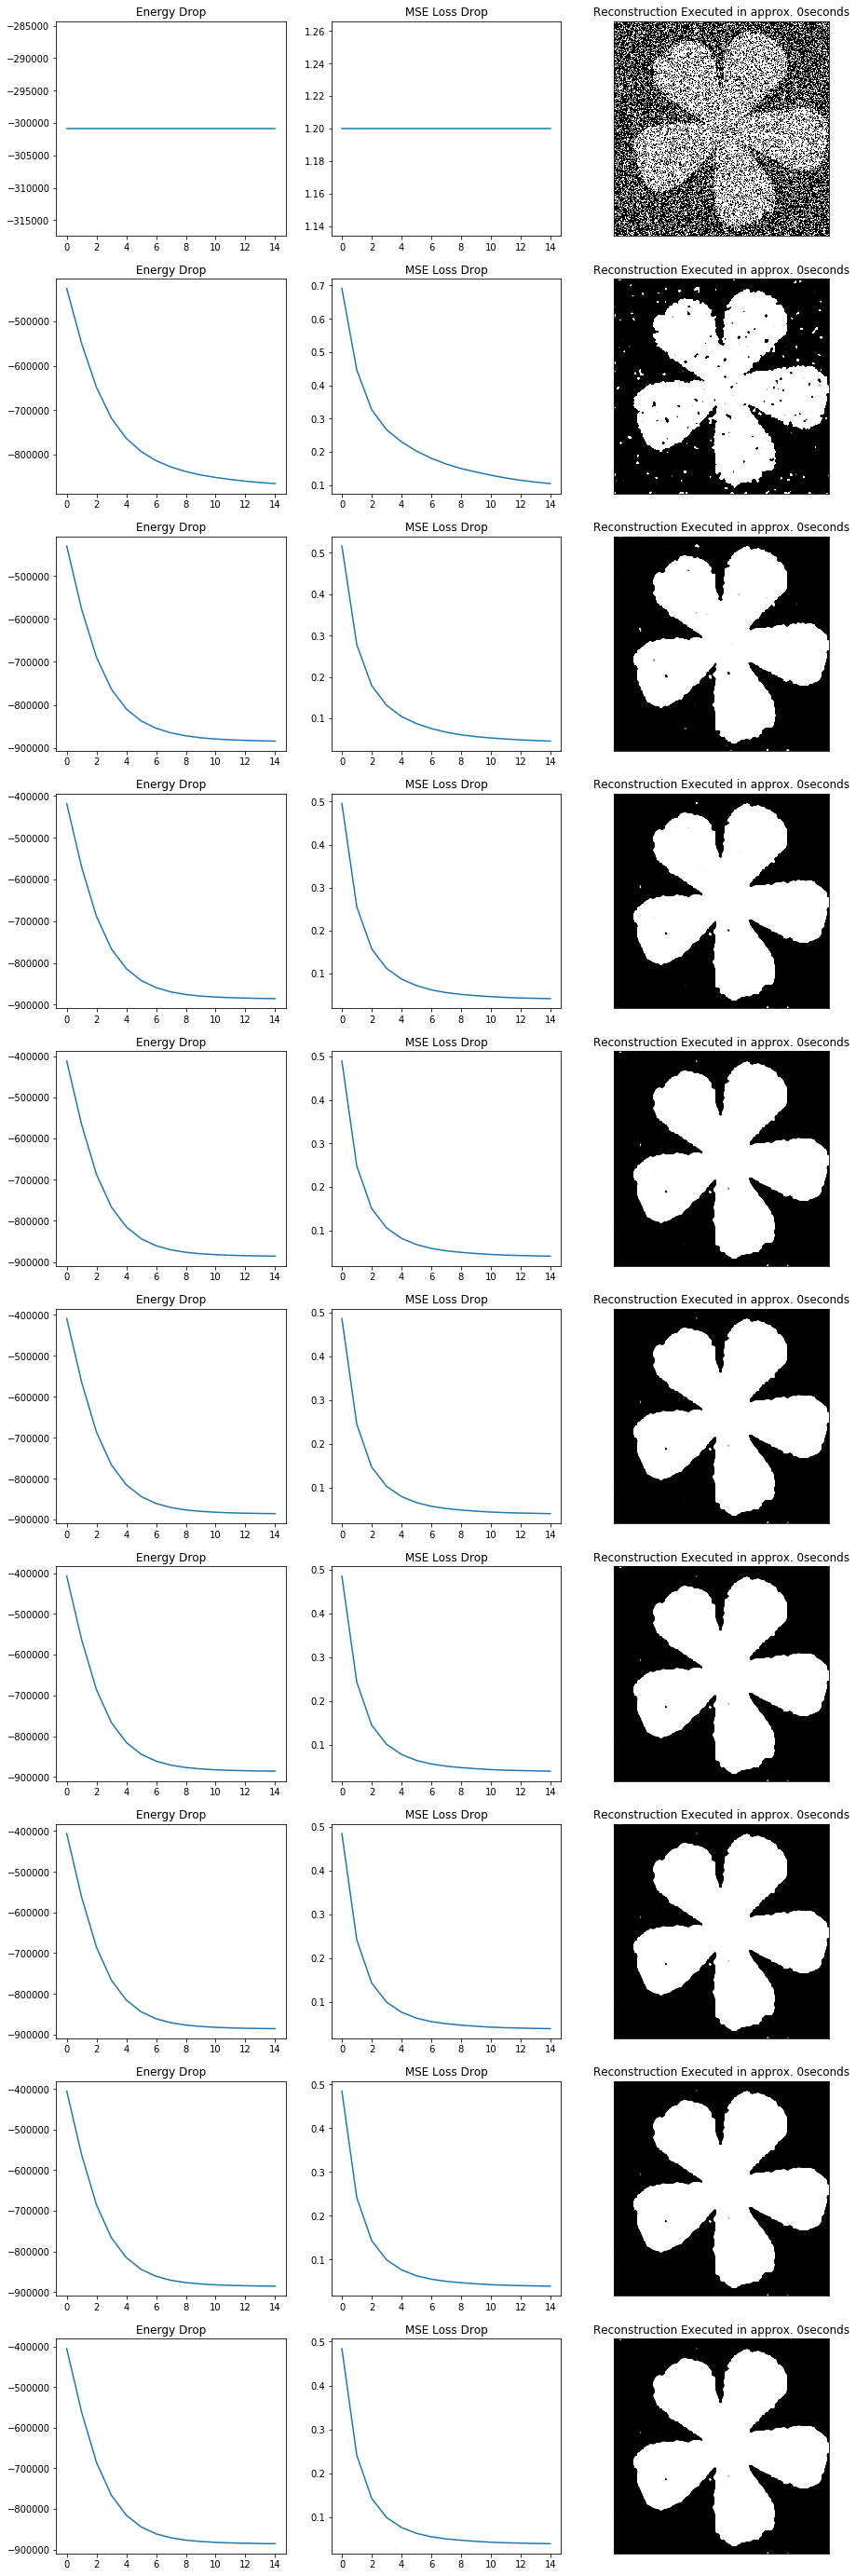

In [29]:
# Lets find out how sigma influences our mean field algorithm
sigmas = np.arange(0.1,5, 0.5)
f, ax = plt.subplots(len(sigmas), 3, figsize=(15,5*len(sigmas)))
for i,s in enumerate(sigmas):
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = meanfield(IMG_NOISY_OBSERVATION, IMG_ORIGINAL, epochs=15, sigma=s)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax[i,0].plot(energies)
    ax[i,0].set_title('Energy Drop')
    ax[i,1].plot(losses)
    ax[i,1].set_title('MSE Loss Drop')
    ax[i,2].imshow(img_estimate, cmap='gray')
    ax[i,2].set_title('Reconstruction Executed in approx. ' +str(int(execution_time)) + 'seconds')
    ax[i,2].get_xaxis().set_visible(False)
    ax[i,2].get_yaxis().set_visible(False)
    
# Its quite similar to above. With the more noise we calculate the more aggressive bits gonna get flipped. 


## Problem 5

Is there something specific to the given image, which makes it more suitable for one or the other method? Feel free to use another image to prove your point?

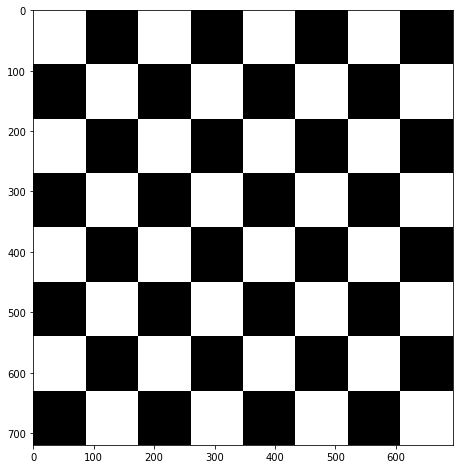

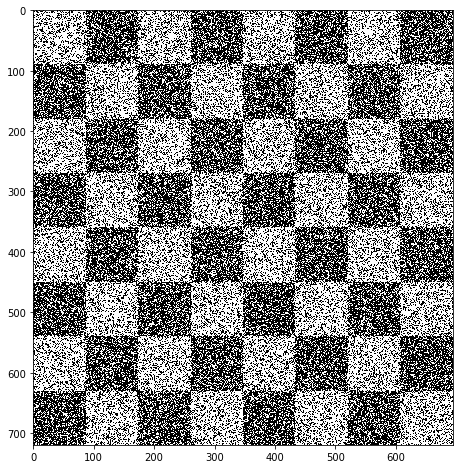

Meanfield(lambda: 0.5, sigma: 1.5, epochs: 15)


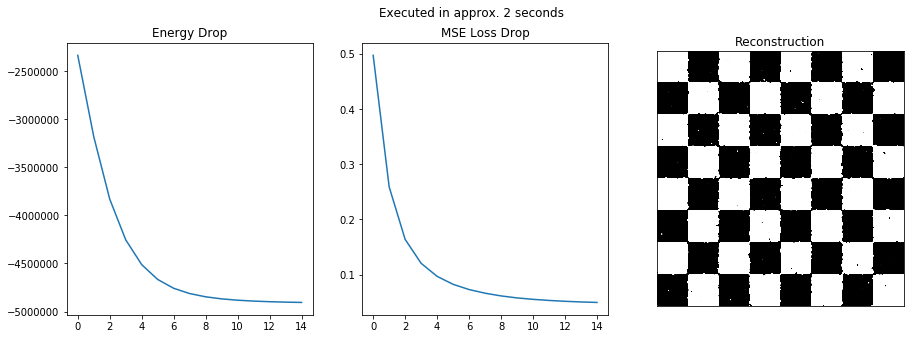

In [244]:
IMG_CHESS = mpimg.imread("chessboard.png")#[:,:,0]/255

IMG_CHESS[IMG_CHESS > 0.5] = 1
IMG_CHESS[IMG_CHESS <= 0.5] = -1
IMG_CHESS = IMG_CHESS[:,:,0]

plt.figure(figsize=(8,8))
plt.imshow(IMG_CHESS, cmap='gray')
plt.show()

# Fix random seed for reproducibility
IMG_CHESS_NOISY = get_noisy_img(IMG_CHESS)
    
plt.figure(figsize=(8,8))
plt.imshow(IMG_CHESS_NOISY, cmap='gray')
plt.show()

# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_CHESS_NOISY, IMG_CHESS, 15)

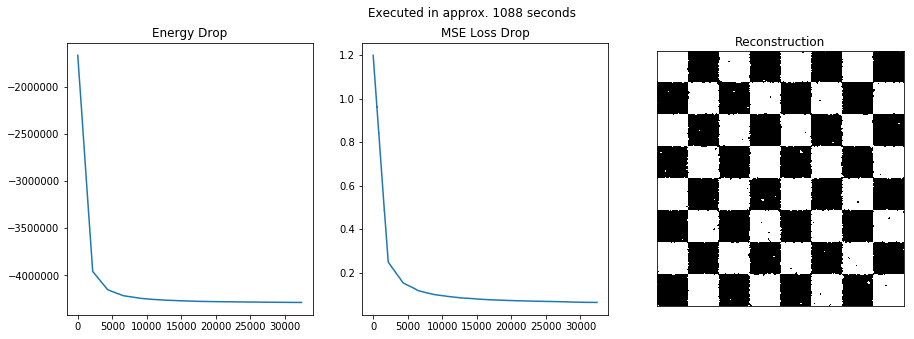

In [245]:
# Evaluate your imlementation of the meanfield
evaluate(metropolis, IMG_CHESS_NOISY, IMG_CHESS, 15)

# Extension: Smooth k-means

For this part of the task please use the Wine data set (different one than before, see [3]). It contains three classes, see more detailed description online. Implement both, plain-vanilla k-means and smooth k-means [1] and compare them on the Wine data set.

Implementation:

In [212]:
import pandas as pd

# load data
names = ["class", 
         "Alcohol", 
         "Malic acid",
         "Ash",
         "Alcalinity of ash",
         "Magnesium",
         "Total phenols",
         "Flavanoids",
         "Nonflavanoid phenols",
         "Proanthocyanins",
         "Color intensity",
         "Hue",
         "OD280/OD315 of diluted wines",
         "Proline"]
csv = pd.read_csv('wine.data', sep=',', header=None, names=names)
data = csv.as_matrix()

label = data[:, 0]-1
data = data[:,1:]

def map_labels(y_truth, y_pred, n_clusters=3):
    from itertools import permutations
    perms = set(permutations(list(range(0,n_clusters))))
    best = (-1, 0)
    for k, perm in enumerate(perms):
        y_perm = y_pred.copy()
        for i in range(n_clusters):
            y_perm[y_pred == perm[i]] = i

        correct = np.sum(y_truth == y_perm)
        if correct > best[1]:
            best = (y_perm.copy(), correct)
    return best

from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(data)

In [192]:
def d(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

class KMeansVanilla:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.clusters = None
        
    def kmeans_vanilla(self, X):
        # init params
        m,n = X.shape
        t_max = 50
        self.clusters = np.zeros((self.n_clusters, n))
        old_C = np.zeros((m, 1))
        new_C = np.ones((m, 1))

        # initialize cluster centers randomly 
        for i in range(n):
            self.clusters[:, i] = np.random.uniform(low=X[:, i].min(), high=X[:, i].max(), size=self.n_clusters)
        t = 0
        while not np.all(old_C == new_C) and t < t_max:
            # assign points
            dist = np.zeros((m, self.n_clusters))
            for k in range(self.n_clusters):
                dist[:, k] = d(X, self.clusters[k, :])

            old_C = new_C
            new_C = np.argmin(dist, axis=1)

            # update cluster centers

            for k in range(self.n_clusters):
                self.clusters[k] = np.mean(X[new_C == k], axis=0)
                #print(clusters[k])

            t += 1

        if t == t_max:
            print('warning: did not converge!')
        return new_C


In [213]:
kmeans_vanilla = KMeansVanilla()
label_kmeans_vanilla = kmeans_vanilla.kmeans_vanilla(data)
label_kmeans_vanilla_mapped, correct_vanilla = map_labels(label, label_kmeans_vanilla)
print('accuracy: {}'.format(100/len(label)*correct_vanilla))

accuracy: 96.62921348314607


In [170]:
def get_nn_matrix(X, n_neighbors=5):
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='euclidean')
    neigh.fit(X)
    return neigh.kneighbors(X, return_distance=False)[:, 1:]

class KMeansSmooth:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.clusters = None

    def kmeans_smooth(self, X, Lambda=0.2, Beta=1.0):
        # init params
        m, n = X.shape
        NN = get_nn_matrix(X)

        # init probabilities
        q = np.zeros((m, self.n_clusters))
        for i in range(m):
            q[i, :] = np.random.uniform(low=0, high=10, size=self.n_clusters)
            q[i, :] /= np.sum(q[i, :])

        # init cluster centers
        self.clusters = np.zeros((self.n_clusters, n))
        old_C = np.zeros((m, 1))
        new_C = np.ones((m, 1))

        # initialize cluster centers randomly
        for i in range(n):
            self.clusters[:, i] = np.random.uniform(low=X[:, i].min(), high=X[:, i].max(), size=self.n_clusters)

        # Cost
        H = np.zeros((m, self.n_clusters))

        from scipy.special import logsumexp
        t = 0
        t_max = 50
        while  t < t_max:# and not np.all(old_C == new_C):
            samples = np.random.random_integers(0, m - 1, 50)
            for u in samples: # np.arange(0, m):
                x = X[u]
                for v in range(self.n_clusters):
                    dist = d(x, self.clusters[v], ax=0)
                    neighbors = NN[u]
                    val = 0
                    for neighbor in neighbors:
                        val += np.sum(q[neighbor, [k for k in range(self.n_clusters) if k != v]])
                    H[u, v] = (1-Lambda)*dist + Lambda * val

                def exp_normalize(x):
                    b = x.max()
                    y = np.exp(x - b)
                    return y / y.sum()

                q[u, :] = exp_normalize(-Beta * H[u, :])



            # update cluster centers
            for k in range(self.n_clusters):
                # clusters[k] = np.mean(X[new_C == k], axis=0)
                self.clusters[k] = np.sum(X*q[:, k].reshape(-1,1), axis=0)/np.sum(q[:, k], axis=0)
                # print(clusters[k])

            old_C = new_C
            new_C = np.argmax(q, axis=1)
            t += 1

        if t == t_max:
            pass
            #print('warning: did not converge!')
        else:
            pass
            #print('converged after: {}'.format(t))
        return new_C



In [171]:
lala = np.arange(0, 1.1, 0.1)
for i in lala:
    accuracies = []
    for j in range(10):
        kmeans = KMeansSmooth()
        label_kmeans_smooth = kmeans.kmeans_smooth(data, Lambda=i)
        label_kmeans_smooth_mapped, correct_smooth = map_labels(label, label_kmeans_smooth)
        accuracies.append(100/len(label)*correct_smooth)
    accuracies = np.array(accuracies)
    print('lambda: {} | mean accuracy: {} | median accuracy: {}'.format(i, np.mean(accuracies), np.median(accuracies)))

/Users/simipro/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:39: DeprecationWarning: This function is deprecated. Please call randint(0, 177 + 1) instead


lambda: 0.0 | mean accuracy: 83.65168539325843 | median accuracy: 84.83146067415731
lambda: 0.1 | mean accuracy: 85.05617977528091 | median accuracy: 88.20224719101124
lambda: 0.2 | mean accuracy: 91.51685393258428 | median accuracy: 91.57303370786518
lambda: 0.30000000000000004 | mean accuracy: 91.46067415730337 | median accuracy: 91.57303370786516
lambda: 0.4 | mean accuracy: 93.93258426966293 | median accuracy: 94.66292134831461
lambda: 0.5 | mean accuracy: 92.97752808988764 | median accuracy: 94.66292134831461
lambda: 0.6000000000000001 | mean accuracy: 91.85393258426966 | median accuracy: 94.38202247191012
lambda: 0.7000000000000001 | mean accuracy: 94.71910112359551 | median accuracy: 94.9438202247191
lambda: 0.8 | mean accuracy: 75.7865168539326 | median accuracy: 75.2808988764045
lambda: 0.9 | mean accuracy: 74.04494382022473 | median accuracy: 75.56179775280899
lambda: 1.0 | mean accuracy: 67.24719101123597 | median accuracy: 68.25842696629215


In [220]:
kmeans_smooth = KMeansSmooth()
label_kmeans_smooth = kmeans.kmeans_smooth(data, Lambda=0.6)
label_kmeans_smooth_mapped, correct_smooth = map_labels(label, label_kmeans_smooth)
accuracy = 100/len(label)*correct_smooth
accuracy

/Users/simipro/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:39: DeprecationWarning: This function is deprecated. Please call randint(0, 177 + 1) instead


94.382022471910119

Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.

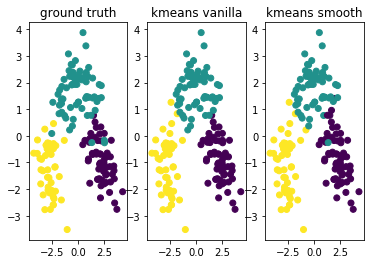

In [214]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

embedding = pca.fit_transform(data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('ground truth')
ax1.scatter(embedding[:,0], embedding[:,1], c=label)

ax2.set_title('kmeans vanilla')
ax2.scatter(embedding[:,0], embedding[:,1], c=label_kmeans_vanilla_mapped)

ax3.set_title('kmeans smooth')
ax3.scatter(embedding[:,0], embedding[:,1], c=label_kmeans_smooth_mapped)

plt.show()

Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.

In [238]:
from sklearn.metrics import confusion_matrix
# lets calculate purity 
# first get confusion matrix cluster vs class
print("Smooth:")
kmeans_smooth = KMeansSmooth()
label_kmeans_smooth = kmeans.kmeans_smooth(data, Lambda=0.5)
label_kmeans_smooth_mapped, correct_smooth = map_labels(label, label_kmeans_smooth)
m = confusion_matrix(label, label_kmeans_smooth_mapped)
print(m)
maxi = 0
for each_row in range(m.shape[0]):
    maxi += m[each_row, :].max()
    
print('Smooth: purity: {}'.format(maxi/len(label)))

print("Vanilla:")

kmeans_vanilla = KMeansVanilla()
label_kmeans_vanilla = kmeans_vanilla.kmeans_vanilla(data)
label_kmeans_vanilla_mapped, correct_vanilla = map_labels(label, label_kmeans_vanilla)
m = confusion_matrix(label, label_kmeans_vanilla_mapped)
print(m)
maxi = 0
for each_row in range(m.shape[0]):
    maxi += m[each_row, :].max()
    
print('Vanilla: purity: {}'.format(maxi/len(label)))

###### my Comment ###
## So kmeans vanilla gets most of the time some higher value by about 1 or 2 percentages
## but it has waaay more variance. Or it seems that way in my opinion. 
## It makes also sense that the smoothing effect is more robust 


Smooth:


/Users/simipro/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:39: DeprecationWarning: This function is deprecated. Please call randint(0, 177 + 1) instead


[[59  0  0]
 [ 4 63  4]
 [ 0  0 48]]
Smooth: purity: 0.9550561797752809
Vanilla:
[[59  0  0]
 [ 4 64  3]
 [ 0  0 48]]
Vanilla: purity: 0.9606741573033708


Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). Does it indicate 3 clusters?

In [219]:
from scipy.spatial import distance

def compute_bic(kmeans,X, labels):
    centers = [kmeans.clusters]
    m = kmeans.n_clusters
    n = np.bincount(labels.astype(np.int32))
    if len(n) < m:
        n = np.vstack((n, np.ones(m-len(n)).reshape(1, -1)))
    print(n,m )
    N, d = X.shape

    # compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(label == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return BIC

for i in range(2, 5):
    kmeans_vanilla = KMeansVanilla(n_clusters=i)
    kmeans_smooth = KMeansSmooth(n_clusters=i)
    
    vanilla_labels = kmeans_vanilla.kmeans_vanilla(data)
    vanilla_labels_mapped, _ = map_labels(label, vanilla_labels, n_clusters=i)
    
    smooth_labels = kmeans_smooth.kmeans_smooth(data, Lambda=0.6)
    smooth_labels_mapped, _ = map_labels(label, smooth_labels, n_clusters=i)
    
    print("Bic of kmeans_smooth: {} | n_clusters: {}".format(compute_bic(kmeans_smooth, data, smooth_labels_mapped), i))
    print("Bic of kmeans_vanilla: {}| n_clusters: {}".format(compute_bic(kmeans_vanilla, data, vanilla_labels_mapped),i))
    
    
################ My Comment to this #############
# so it really does indicate that 2 & 4 clusters are to much. Since best for us is best negative bic. 
# But i had also some runs where 4 were better then 3. 
# Because of the multiple local minima of the cost surface the bic wansn't conclusive about 
# what is better kmeans vanilla or kmeans smooth.


/Users/simipro/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:39: DeprecationWarning: This function is deprecated. Please call randint(0, 177 + 1) instead


[90 88] 2
Bic of kmeans_smooth: -3523.0739390292865 | n_clusters: 2
[113  65] 2
Bic of kmeans_vanilla: -3616.1993320108477| n_clusters: 2
[64 62 52] 3
Bic of kmeans_smooth: -4266.985454449243 | n_clusters: 3
[62 65 51] 3
Bic of kmeans_vanilla: -3952.4996115483523| n_clusters: 3
[68 52 47 11] 4
Bic of kmeans_smooth: -4058.39363566676 | n_clusters: 4
[60 49 47 22] 4
Bic of kmeans_vanilla: -4413.624337276393| n_clusters: 4


# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in this box. This will help us improve our exercises. Thank you in advance!

It was a really fun exercise! I really like clustering. <br>
One thing that I encountered frequently in the last view exercises. Is that there is no image that represents<br>
somewhat of an optimal solution. This would be quite helpfull at times. <br>
And and yes you have a small error in the add noise function i think. See mine for one that works also with non square images. 